<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/Widen00-Lab3/Lab3/Widen00_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Approximations**
**Joel Widén**

# **Abstract**

This report is investigating approximation by using $L^2$ projections on linear piecewise functions. This is the cornerstone of finite element methods which allows for calculations of
functions and differential equations over difficuilt domains.

The objective is to make one such approximation of a scalar function in one dimension. The result is that the approximations recreates the original function and is better with a finer mesh. A finer mesh is therefore better for accuracy but takes longer to compute.

#**About the code**

This is a report in the course DD2363 Methods in Scientific Computing. The author of this file is Joel Widén, joelwid@kth.se.

# **Set up environment**

In [44]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Numbered algorithms, equations and chapter references used in this report is from the DD2363 course book Methods in Computational Science by Johan Hoffman if not stated otherwise.

Approximative methods are used throughout science and engineering to be able to solve complex problems over complex domains. One of the most widely used approximation methods is that of the finite element method which this lab is investigating the fundamentals of. This lab is focusing on the $L^2$ projection onto linear piecewise continious basis functions to build up an approximation using discrete elements.

This computer lab is split into assignments. The mandatory assignment is to create:

**Assignment 1** Function: L2 projection to pw linear approximation over mesh in 1D

* *Input:* function $f(x)$, 1D mesh with nodes $(x0,...,xn)$
* *Output:* vector of L2 projection of $f(x)$ evaluated in $(x0,...,xn)$
* *Test:* verify accuracy and convergence rate against exact function


# **Method**



**Assignment 1**

This method is heavily based on chapters 9.3 and 9.5. The two major algorithms used are algorithm 9.2 for assembleing the global matrix and 9.1 for performing the actual projection onto the linear piecewise basis.

In [45]:
#L2 projection on pw to linear approximation over mesh in 1D

#Class defining the object of mapping local to global values
class loc2globmap:
  def __init__(self, A_map, b_map, dof):
    self.A_map = A_map
    self.b_map = b_map
    self.dof = dof

#Reference function
def f(x):
  fx =np.cos(x)
  return fx

#Input x, interval nr k, mesh and if it is the 0 or 1 polynomial in nr
def lin_lagrange_pol(x, mesh, k, nr):
  x_k = mesh[k+1]
  x_k_m1 = mesh[k]
  h_k = x_k - x_k_m1
  if nr == 0:
    lambdax =  (x_k - x)/h_k
  else:
    lambdax = (x- x_k_m1)/h_k
  return lambdax

#Returns the number of shape functions per element
def get_no_local_shape_functions(k):
  #since we have a linear basis V, q is 2 for all elements
  q = 2
  return q

#Define the local to global maps
def get_local_to_global_map(k):
  A_map = np.array([[k, k+1],[k,k+1]])
  b_map = np.array([k, k+1])
  dof = np.array([k, k+1])
  loc2glob = loc2globmap(A_map, b_map, dof)
  return loc2glob

#Integrating the vector using trapezoidal rule
def integrate_vector(f, k, i, mesh):
  a = mesh[k]
  b = mesh[k+1]
  # Trapezoidal rule
  bi = f(a)*lin_lagrange_pol(a, mesh, k, i)*0.5*(b-a) + f(b)*lin_lagrange_pol(b, mesh, k, i)*0.5*(b-a)
  return bi

#Integrating the matrix. This is only valid for continious piecewise linear
#lagrange polynomials
def integrate_matrix(k, i, j,mesh):
  hk = mesh[k+1]-mesh[k]
  if i == j:
    aij = hk/3
  else:
    aij = hk/6
  return aij

#Add local vector to global vector
def add_to_global_vector(b, b_k, loc2glob):
  b[loc2glob.b_map[0]:loc2glob.b_map[1]+1] = b[loc2glob.b_map[0]:loc2glob.b_map[1]+1] + b_k
  return b

#Add local matrix to global matrix
def add_to_global_matrix(A, a_k, loc2glob):
  A[loc2glob.A_map[0][0]:loc2glob.A_map[0][1]+1, loc2glob.A_map[1][0]:loc2glob.A_map[1][1]+1] = A[loc2glob.A_map[0][0]:loc2glob.A_map[0][1]+1, loc2glob.A_map[1][0]:loc2glob.A_map[1][1]+1] + a_k
  return A

#From algorithm 9.2 to assemble the local matrixes into the global matrix
def assembly_system(f, A, b, mesh):
  no_elements = len(b)-1
  for k in range(0, no_elements):
    q = get_no_local_shape_functions(k)
    loc2glob = get_local_to_global_map(k)
    b_k = np.zeros(q)
    a_k = np.zeros((q, q))
    for i in range(0, q):
      b_k[i] = integrate_vector(f, k, i, mesh)
      for j in range(0, q):
        a_k[i, j] = integrate_matrix(k, i, j, mesh)
    b = add_to_global_vector(b, b_k, loc2glob)
    A = add_to_global_matrix(A, a_k, loc2glob)
  return A, b


#Get coordinates alpha by solving matrix equation
def coordinates(A, b):
  A_inv = np.linalg.inv(A)
  alpha = A_inv.dot(b)
  return alpha

#Find what subinterval x is in
def find_subinterval(x, mesh):
  for i in range(0, len(mesh)-1):
    if mesh[i]<= x <=mesh[i+1]:
      k = i
      break
  return k

#Extract local dofs from alpha using the map from local to global
def get_local_dofs(alpha, loc2glob):
  beta = [alpha[loc2glob.dof[0]], alpha[loc2glob.dof[1]]]
  return beta

#This function is inspired by algorithm 9.1 but modified to calculate
#phi
def eval_pwp_function(alpha, x, q, mesh):
  k = find_subinterval(x, mesh)
  loc2glob = get_local_to_global_map(k)
  beta = get_local_dofs(alpha, loc2glob)
  f = 0
  for j in range(0,len(beta)):
    lambdax= lin_lagrange_pol(x, mesh, k, j)
    f += beta[j]*lambdax
  return f

"""Performing linear projection calculations.
This can be seen as the master function doing assembly and projection."""
def l2_to_pw(f, mesh):

  A = np.zeros((len(mesh), len(mesh)))
  b = np.zeros(len(mesh))

  #Assemble
  A, b = assembly_system(f, A, b, mesh)

  #Get alpha coordinates
  alpha = coordinates(A, b)

  #Calculate the projected function in the nodal points
  l2_to_pw_mesh = np.zeros_like(mesh)
  for i in range(0, len(mesh)):
    x = mesh[i]
    q = 1
    l2_to_pw_mesh[i] = eval_pwp_function(alpha, x, q, mesh)

  #Calculate for inner range to avoid rounding errors in mesh edge, this is just
  #for fun to calculate points other than the node values
  """This part is not part of the assignment"""
  x_0 = mesh[1]
  x_m1 = mesh[-2]
  #This is put as interval for mesh to get the points xn
  interval = 0.01
  nr_points = round((x_m1 - x_0)/interval)
  x_vec = np.zeros(nr_points+1)
  x = x_0
  for i in range(0, nr_points+1):
    x_vec[i] = x
    x += interval
  l2_to_pw = np.zeros_like(x_vec)
  for i in range(0, len(x_vec)):
    x = x_vec[i]
    q = 1
    l2_to_pw[i] = eval_pwp_function(alpha, x, q, mesh)
  """------------------------------------------------"""

  return l2_to_pw_mesh, l2_to_pw, alpha, x_vec

#Generate mesh
x_0 = -4
x_n = 4
interval = 0.1
mesh = np.arange(x_0 ,x_n+interval, interval)

#Call function to calculate
f_approx_mesh, f_approx, alpha, x_vec = l2_to_pw(f, mesh)

#"Linear" range for exact funtion
t = np.arange(x_0, x_n, 0.001)

#Iterate over different mesh fineness
divisions = 100
error_vec = np.zeros(divisions)
int_vec = np.zeros(divisions)
t_vec = np.zeros(divisions)
d = 0
for p in range(1, divisions+1):
  interval = 1/p
  mesh_int = np.arange(x_0 ,x_n+interval, interval)
  # Time the calculation
  t1 = time.perf_counter_ns()
  f_approx_mesh_int, f_approx, alpha, x_vec = l2_to_pw(f, mesh_int)
  t2 = time.perf_counter_ns()
  t_tot = (t2-t1)/(10**9)
  f_exact_mesh = np.zeros_like(f_approx_mesh_int)
  for i in range(0, len(f_exact_mesh)):
    f_exact_mesh[i] = f(mesh_int[i])
  error_vec[d] = np.linalg.norm(f_approx_mesh_int - f_exact_mesh)
  int_vec[d] = interval
  t_vec[d] = t_tot
  d += 1


# **Results**

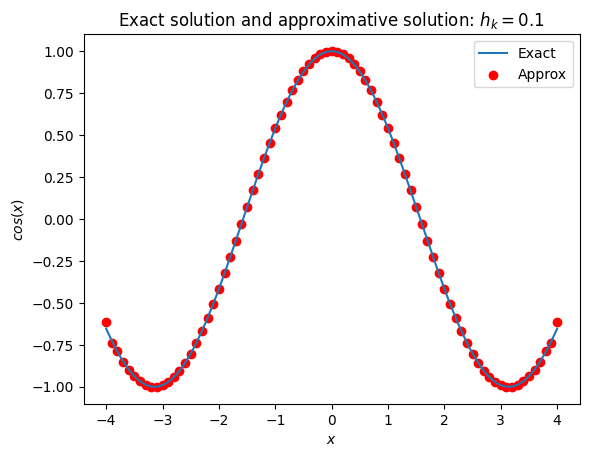

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

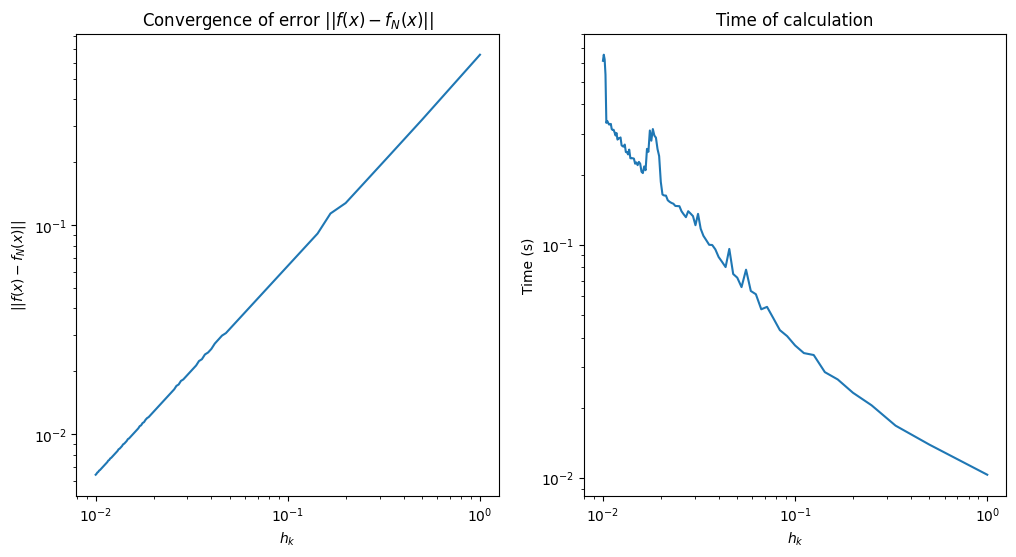

In [47]:
# Plot all results

plt.figure(1)
plt.plot(t, f(t), label="Exact")
plt.scatter(mesh, f_approx_mesh, color='r', label ="Approx")
plt.title("Exact solution and approximative solution: $h_k = 0.1$")
plt.xlabel("$x$")
plt.ylabel("$cos(x)$")
plt.legend()
plt.show()

plt.figure(2)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.loglog(int_vec, error_vec)
plt.title("Convergence of error $||f(x) - f_N(x)||$")
plt.ylabel("$||f(x) - f_N(x)||$")
plt.xlabel("$h_k$")
plt.show

plt.subplot(122)
plt.loglog(int_vec, t_vec)
plt.title("Time of calculation")
plt.ylabel("Time (s)")
plt.xlabel("$h_k$")
plt.show

# **Discussion**


The approximation follows the original function well as seen in the upper graph when the exact function is plotted against the nodal values of the approximation.

In the lower figure the convergence of the error of the functions can be seen. The speed of the convergence increases rapidly with a decrease in the interval between the nodes $h_k$ which is clearly seen. However there is a tradeoff as can be seen in the right picture which features a dramatic increase in time for the finer mesh.

There is a tradeoff to be made regarding accuracy and speed of the calculation. This is one of the reasons a lot of computer power is needed for very detailed simulations of this kind.

The largest advantage is the ability to quickly calculate different functions using the same linear basis which is a useful tool. Using the same linear basis a lot of different functions can be evaluated easily with great accuracy given that the mesh is fine enough.